## Import libraries needed for this project

In [1]:
#!pip install seaborn
#!pip install scipy
#!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Data Collection

### The data used in this project is from kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download). 

In [2]:
## read the data from csv file
df = pd.read_csv('hotel.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


## Data Cleaning

In [3]:
## see whether there are missing data
df.loc[np.sum(df.isna(),axis = 1)>0,:]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


In [4]:
## rename the columns: shorten the names of some columns, such as required_car_parking_space = parking; room_type_reserved = room_type; etc.
column_rename_map = {
    'no_of_weekend_nights': 'weekend_nights',
    'no_of_week_nights': 'week_nights',
    'type_of_meal_plan': 'meal_plan',
    'required_car_parking_space': 'parking',
    'room_type_reserved': 'room_type',
    'market_segment_type':'market',
    'no_of_previous_cancellations':'prev_cancellations',
    'no_of_previous_bookings_not_canceled': 'prev_bookings',
    'avg_price_per_room': 'avg_price',
    'no_of_special_requests': 'special_requests'
}
df = df.rename(columns=column_rename_map)
df.head()

,Booking_ID,no_of_adults,no_of_children,weekend_nights,week_nights,meal_plan,parking,room_type,lead_time,arrival_year,arrival_month,arrival_date,market,repeated_guest,prev_cancellations,prev_bookings,avg_price,special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


#### Convert categorical data using dummy variables

In [5]:
# meal_plan column
#df['meal_plan'].unique()
mealplan_dict = {
    'Not Selected': 0,
    'Meal Plan 1': 1,
    'Meal Plan 2': 2,
    'Meal Plan 3': 3
}
df['meal'] = df['meal_plan'].map(lambda x: mealplan_dict[x])

In [6]:
# room_type column
#df['room_type'].unique()
room_map = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}
df['room'] = df['room_type'].map(lambda x: room_map[x])

In [7]:
# market column
#df['market'].unique()
market_map = {
    'Offline': 0,
    'Online': 1,
    'Corporate': 2,
    'Aviation': 3,
    'Complementary': 4
}
df['mkt'] = df['market'].map(lambda x: market_map[x])

In [8]:
# booking status column (for ANOVA test 1 below)
booking_map = {
    'Not_Canceled': 0,
    'Canceled': 1
}
df['cancel'] = df['booking_status'].map(lambda x: booking_map[x])

In [9]:
df['no_of_children'].unique()

array([ 0,  2,  1,  3, 10,  9], dtype=int64)

In [10]:
# no_of_children column (for ANOVA test 2 below)
child_map = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    9: 1,
    10: 1
}
df['bring_child'] = df['no_of_children'].map(lambda x: child_map[x])

In [11]:
# create a season column based on the value of arrival_month column (spring: 1; summer: 2; fall: 3; winter: 4)
def map_season(month):
    if month >= 3 and month <= 5:
        return 1
    elif month >= 6 and month <= 8:
        return 2
    elif month >= 9 and month <= 11:
        return 3
    elif month == 12 or month <= 2:
        return 4
    else:
        return 'error'
df['season'] = df['arrival_month'].apply(map_season)

#### Examine whether there are outliers for numeric columns

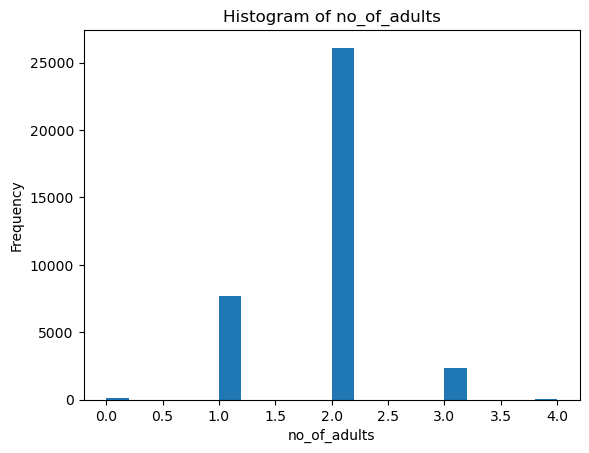

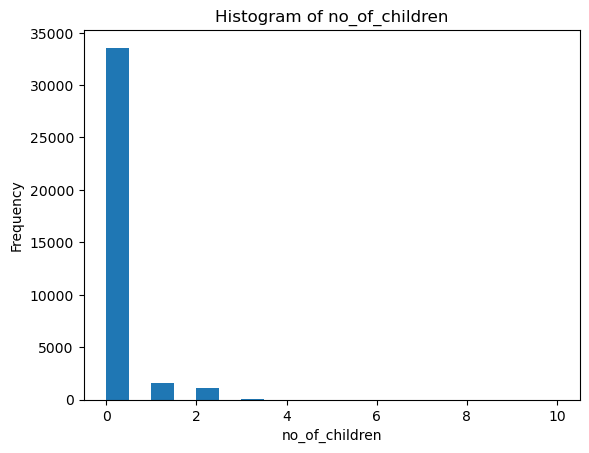

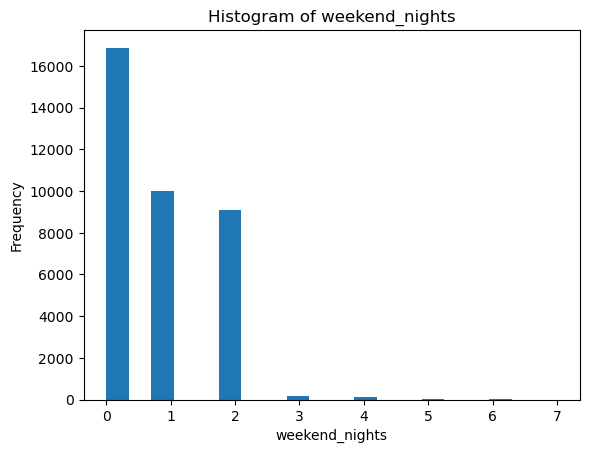

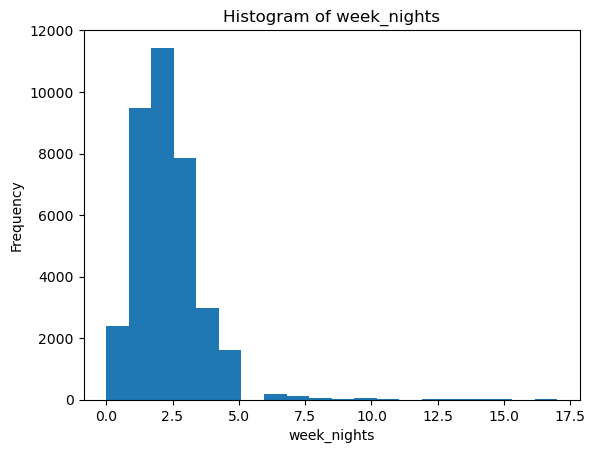

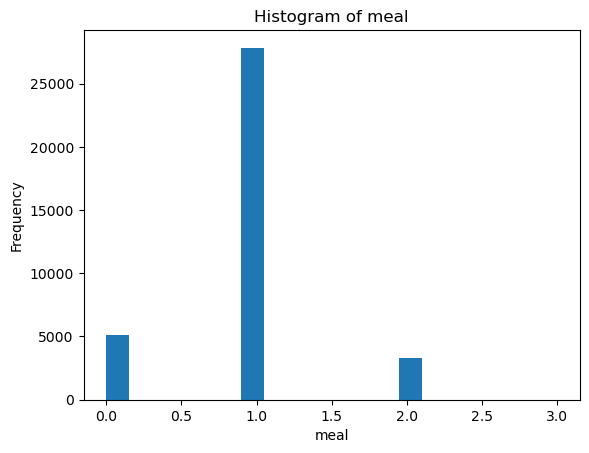

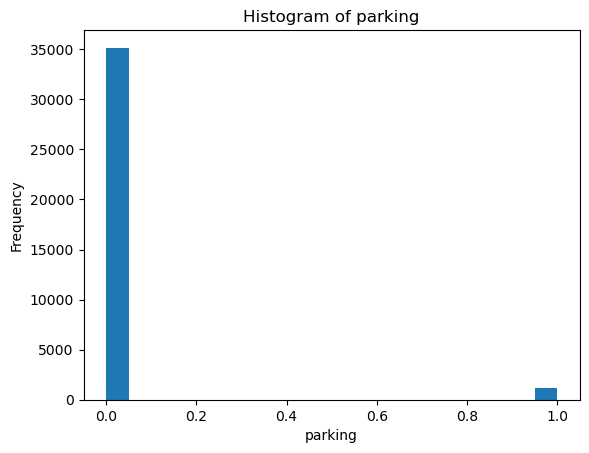

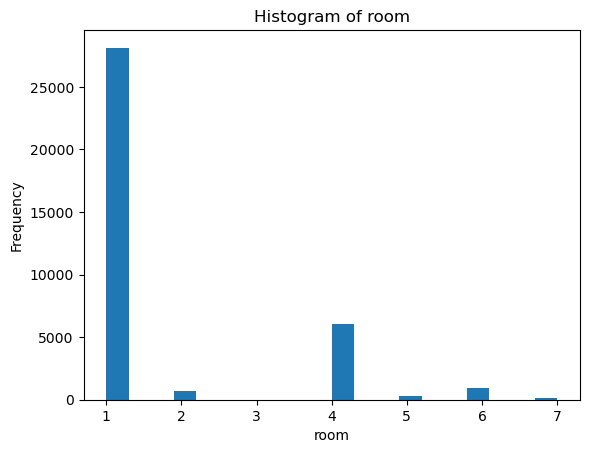

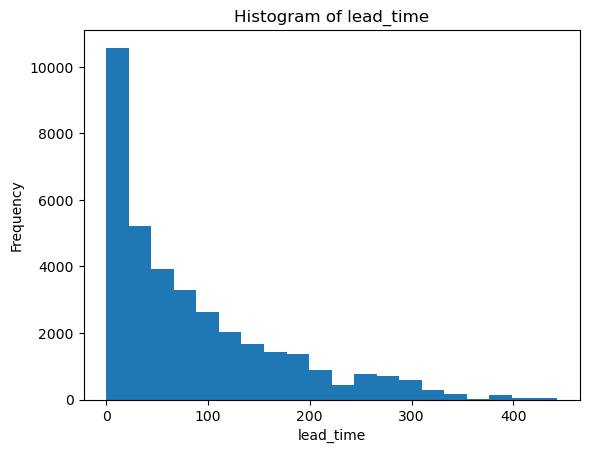

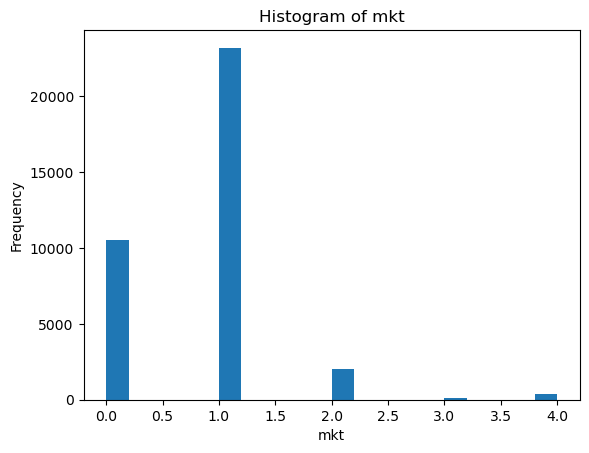

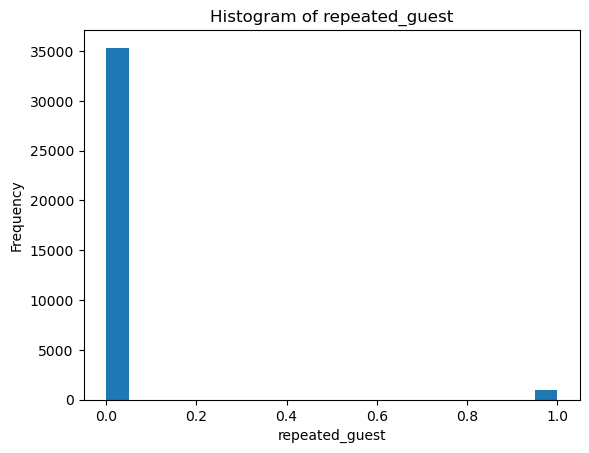

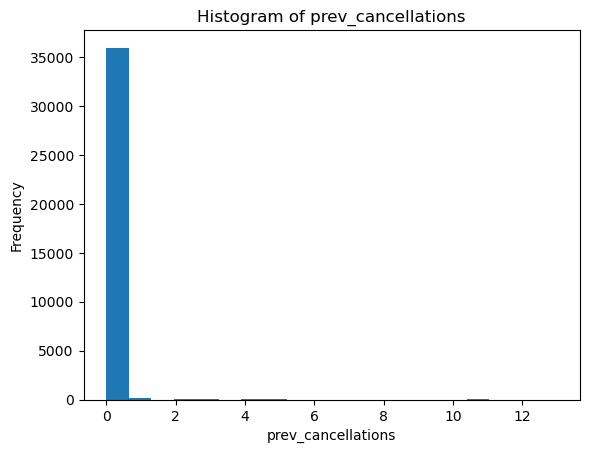

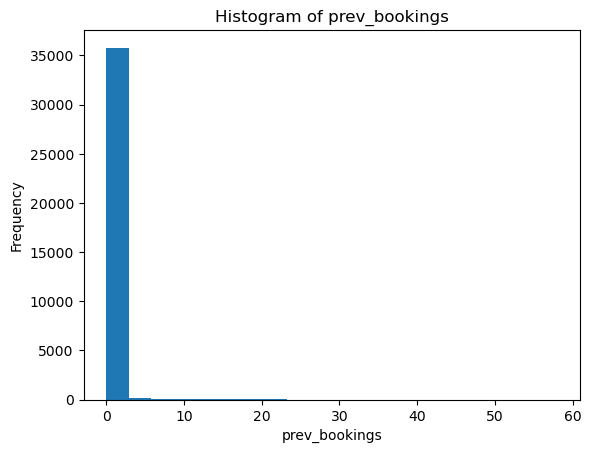

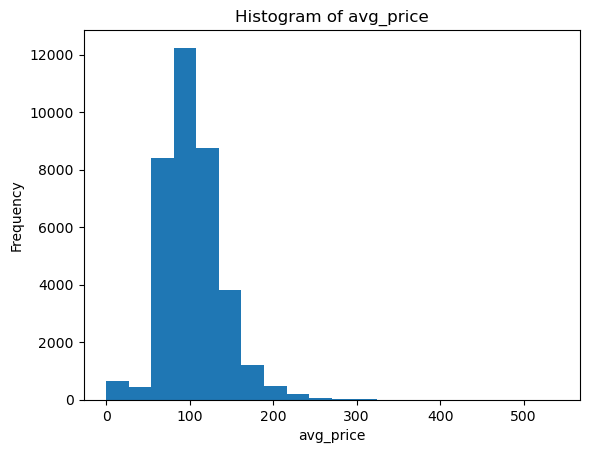

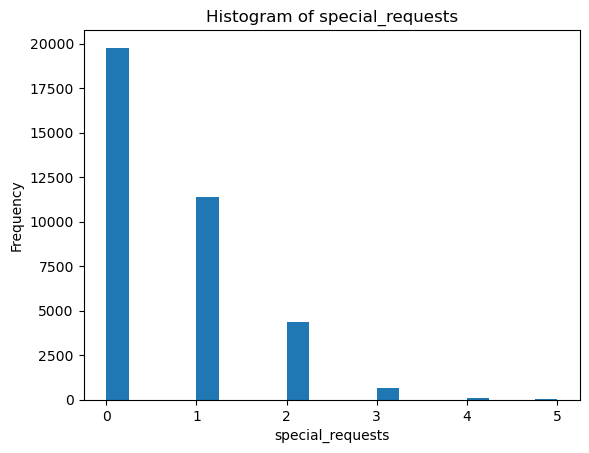

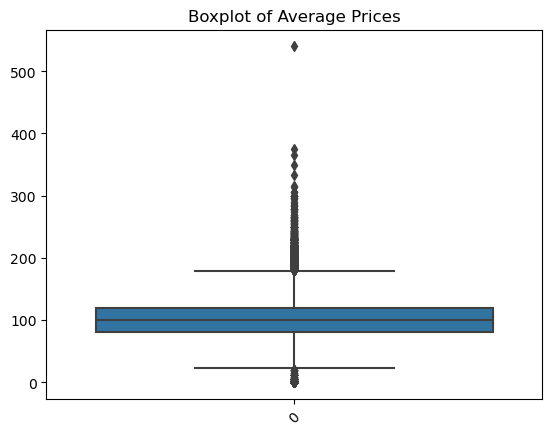

       no_of_adults  no_of_children  weekend_nights   week_nights  \
count  36275.000000    36275.000000    36275.000000  36275.000000   
mean       1.844962        0.105279        0.810724      2.204300   
std        0.518715        0.402648        0.870644      1.410905   
min        0.000000        0.000000        0.000000      0.000000   
25%        2.000000        0.000000        0.000000      1.000000   
50%        2.000000        0.000000        1.000000      2.000000   
75%        2.000000        0.000000        2.000000      3.000000   
max        4.000000       10.000000        7.000000     17.000000   

               meal       parking          room     lead_time           mkt  \
count  36275.000000  36275.000000  36275.000000  36275.000000  36275.000000   
mean       0.949966      0.030986      1.708890     85.232557      0.804604   
std        0.480191      0.173281      1.399851     85.930817      0.646881   
min        0.000000      0.000000      1.000000      0.000000 

In [12]:
df_num = df[['no_of_adults','no_of_children','weekend_nights','week_nights','meal','parking','room','lead_time','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]

# Histogram to visualize discrete columns' distribution
for i in df_num.columns:
    plt.hist(df_num[i], bins=20) 
    plt.title(f'Histogram of {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()

# Boxplot to visualiza continuous data's distribution
sns.boxplot(data=df_num['avg_price'])
plt.xticks(rotation=45)
plt.title('Boxplot of Average Prices')
plt.show()

# Summary statistics to identify potential outliers
summary_stats = df_num.describe()
print(summary_stats)

In [13]:
# Interquartile Range (IQR) to identify outliers in average prices
Q1 = df_num['avg_price'].quantile(0.25)
Q3 = df_num['avg_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df_num[((df_num['avg_price'] < lower_bound) | (df_num['avg_price'] > upper_bound))]
print("Outliers based on IQR:")
print(outliers_iqr)

Outliers based on IQR:
       no_of_adults  no_of_children  weekend_nights  week_nights  meal  \
60                2               2               0            1     1   
63                1               0               0            1     1   
114               2               2               2            2     1   
127               2               2               0            2     1   
145               1               0               0            2     1   
...             ...             ...             ...          ...   ...   
36221             2               2               2            4     1   
36227             2               2               0            1     1   
36250             1               0               0            2     2   
36263             1               0               2            1     1   
36269             2               2               0            1     1   

       parking  room  lead_time  mkt  repeated_guest  prev_cancellations  \
60          

In [14]:
# Drop outliers from the original DataFrame
#df = df.drop(outliers_iqr.index)
#df.shape

## Data Analysis

In [15]:
## Are the cancel rates for customers with different room types different statistically? 
room_ANOVA = ols('cancel ~ room', data=df).fit()
anova_table1 = sm.stats.anova_lm(room_ANOVA, typ=2)
print(anova_table1)

               sum_sq       df          F    PR(>F)
room         4.222254      1.0  19.175814  0.000012
Residual  7986.822543  36273.0        NaN       NaN


#### As shown in the table above, the p-value for room (room_type) variables is 0.000012, which is way less than 0.05, therefore, we can conclude that the cancel rates for customers with different room types are statistically inconsistent (different).

In [16]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_room = df['room'].corr(df['cancel'])
print("Pearson's correlation coefficient:", pearsonr_room)

Pearson's correlation coefficient: 0.022986370186607836


#### A Pearson's r of 0.0229863701866078 indicates that there is a weak positive correlation between room type and booking status, in spite of the inconsistent cancel rates among customers with different room types.

In [17]:
## Do those who bring their children with them honor their reservation more than those who do not?
child_ANOVA = ols('cancel ~ no_of_children', data=df).fit()
anova_table2 = sm.stats.anova_lm(child_ANOVA, typ=2)
print(anova_table2)

                     sum_sq       df          F        PR(>F)
no_of_children     8.743340      1.0  39.731293  2.947637e-10
Residual        7982.301457  36273.0        NaN           NaN


#### As shown in the table above, the p-value for children (no_of_children) variables is 2.947e-10, which is way less than 0.05, therefore, we can conclude that the cancel rates for customers who bring different numbers of children with them are statistically unconsistent (different).

In [18]:
## Now, let's see whether the no_of_children is correlated with booking status, and if so, the direction of such correlation
pearsonr_child = df['no_of_children'].corr(df['cancel'])
print("Pearson's correlation coefficient:", pearsonr_child)

Pearson's correlation coefficient: 0.033077820912251074


#### A Pearson's r of 0.022078 indicates that there is a weak positive correlation between number of children and booking status, in spite of the inconsistent cancel rates among customers who bring different numbers of children with them.

#### Meanwhile, we wonder whether simply categorizing customers into two groups based on whether they bring children with them (instead of based on the number of child they bring) would yield different results.

In [19]:
pearsonr_children = df['bring_child'].corr(df['cancel'])
print("Pearson's correlation coefficient:", pearsonr_children)

Pearson's correlation coefficient: 0.026646782775722855


#### A Pearson's r of 0.02665 indicates that there is a weak positive correlation between whether a customer brings child and whether the customer cancels the booking.

In [20]:
## Is there seasonality for cancel rate? (Whether cancel rate are inconsistent throughout a year) 
month_ANOVA = ols('cancel ~ arrival_month', data=df).fit()
anova_table3 = sm.stats.anova_lm(month_ANOVA, typ=2)
print(anova_table3)

                    sum_sq       df         F  PR(>F)
arrival_month     1.008322      1.0  4.577559  0.0324
Residual       7990.036475  36273.0       NaN     NaN


#### As shown in the table above, the p-value for month (arrival_month) variables is 0.0324, which is less than 0.05, therefore, we can conclude that the cancel rates for customers arrived in different months of a year are statistically inconsistent (different).

In [21]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_month, p_value_month = pearsonr(df['arrival_month'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_month)
print("P-value for the correlation:", p_value_month)

Correlation coefficient between arrival month and booking status: -0.011233054158994647
P-value for the correlation: 0.032399975828473336


#### A Pearson's r of -0.011233 indicates that there is a weak negative correlation between arrival month and booking status, in spite of the inconsistent cancel rates among customers who arrived in different months of a year.

#### Meanwhile, we wonder whether categorizing customers into 4 groups based on the season they arrived (spring,summer,fall,winter) would yield different results.

In [22]:
pearsonr_season, p_value_season = pearsonr(df['season'], df['cancel'])
print("Correlation coefficient between season and booking status:", pearsonr_season)
print("P-value for the correlation:", p_value_season)

Correlation coefficient between season and booking status: -0.12447779496289747
P-value for the correlation: 3.3530646363147126e-125


#### A Pearson's r of -0.1245 indicates that there is a weak negative correlation between arrival season and booking status.

We also want to examine whether the cancel rates are influenced by the year.

In [23]:
## Is the cancel rate in 2017 different from 2018? 
cancel_rates_2017 = df[df['arrival_year'] == 2017]['cancel'].mean()
cancel_rates_2018 = df[df['arrival_year'] == 2018]['cancel'].mean()

# Perform t-test to check for significant difference
t_stat, p_value = ttest_ind(df[df['arrival_year'] == 2017]['cancel'], 
                            df[df['arrival_year'] == 2018]['cancel'])

# Print cancellation rates and p-value
print("Cancellation rate in 2017:", cancel_rates_2017)
print("Cancellation rate in 2018:", cancel_rates_2018)
print("P-value for the t-test:", p_value)

Cancellation rate in 2017: 0.1475284003684372
Cancellation rate in 2018: 0.3670575585497799
P-value for the t-test: 2.0857790629440148e-260


Since p-value of the t-test is very small and much less than 0.05, so at significantce level 5%, we can reject the null hypothesis and conclude that cancel rate in 2017 is significantly different from that in 2018.

In [24]:
# check correlation with cancel status
pearsonr_year, p_value_year = pearsonr(df['arrival_year'], df['cancel'])
print("Correlation coefficient between arrival year and booking status:", pearsonr_year)
print("P-value for the correlation:", p_value_year)


Correlation coefficient between arrival year and booking status: 0.1795288942040949
P-value for the correlation: 2.085779062967209e-260


A Pearson's r of 0.1795 indicates that there is a positive correlation between arrival season and booking status. P-value being less than 0.05 indicates that this correlation between year and cancel status is significant at 5% level.

Generally check whether the DVs are correlated with IV:

In [25]:
# Define independent variables (features) and dependent variable (outcome)
X1 = df[['no_of_adults','no_of_children','weekend_nights','week_nights','meal','parking','room','lead_time','arrival_year','arrival_month','arrival_date','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]
y1 = df['cancel'] 

# Calculate pearsonr correlation coefficient for each independent variable
correlation_coefficients = []
for col in X1.columns:
    corr_coef, p_value = pearsonr(X1[col], y1)
    correlation_coefficients.append((col, corr_coef, p_value))
correlation_df = pd.DataFrame(correlation_coefficients, columns=['Independent Variable', 'Correlation Coefficient', 'P-value'])
print(correlation_df)

   Independent Variable  Correlation Coefficient        P-value
0          no_of_adults                 0.086920   8.848338e-62
1        no_of_children                 0.033078   2.947637e-10
2        weekend_nights                 0.061563   8.340702e-32
3           week_nights                 0.092996   1.727216e-70
4                  meal                 0.049374   4.996633e-21
5               parking                -0.086185   9.125922e-61
6                  room                 0.022986   1.195478e-05
7             lead_time                 0.438538   0.000000e+00
8          arrival_year                 0.179529  2.085779e-260
9         arrival_month                -0.011233   3.239998e-02
10         arrival_date                 0.010629   4.292948e-02
11                  mkt                -0.048733   1.589689e-20
12       repeated_guest                -0.107287   2.523315e-93
13   prev_cancellations                -0.033728   1.315207e-10
14        prev_bookings                -

As suggested from the table above, all our independent variables have significant correlations with our dependent variable since p-values are all smaller than 5%. The top three strongly correlated factors are Number of days between the date of booking and the arrival date(lead_time), Total number of special requests made by the customer(special_requests), and Year of arrival date(arrival_year).

## Data Visualization (draw it when needed)

## Modeling

Check assumptions of logistic regression:

1. Binary Outcome: The outcome variable(cancel) is binary, 1 for canceled, 0 for not.
2. Independence of Observations: Each observation(row) is a unique booking.
3. Large Sample Size: Our dataset has 36275 rows of data.
4. No Outliers: We checked outliers at the beginning of the project.

Check no multicolinearity between independent variables:

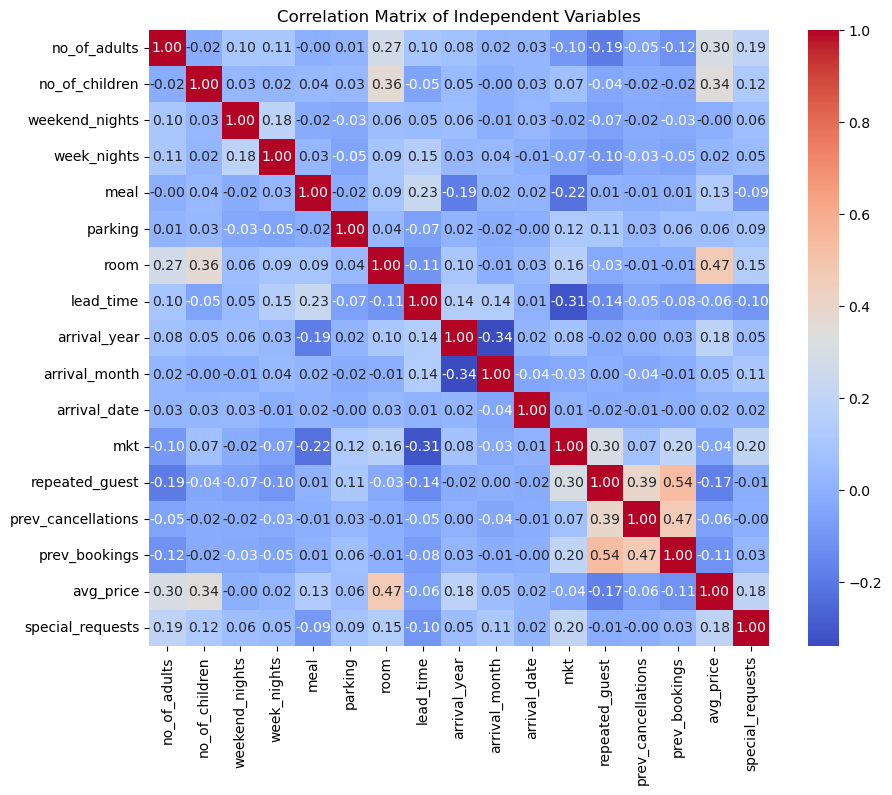

In [26]:
# Calculate correlation matrix
correlation_matrix = X1.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Independent Variables')
plt.show()

In [27]:
## predictive model for whether a customer, given information about the booking, would honor or cancel the reservation

# train-test split to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=9)

# fit the Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

coefficients = model.coef_[0]
intercept = model.intercept_
coefficients_df = pd.DataFrame({'Feature': X1.columns, 'Coefficient': coefficients})
print("Intercept:", intercept)
print("\nCoefficients:")
print(coefficients_df)

Accuracy: 0.7903514817367333
Intercept: [-0.00010568]

Coefficients:
               Feature  Coefficient
0         no_of_adults     0.011782
1       no_of_children    -0.052556
2       weekend_nights     0.229234
3          week_nights     0.043320
4                 meal    -0.357408
5              parking    -0.117714
6                 room    -0.111705
7            lead_time     0.014378
8         arrival_year    -0.001883
9        arrival_month    -0.059822
10        arrival_date     0.004772
11                 mkt     0.519745
12      repeated_guest    -0.041206
13  prev_cancellations    -0.017880
14       prev_bookings    -0.188615
15           avg_price     0.024628
16    special_requests    -1.309142


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
